Found 58 common professions
                                 Cosine_Similarity
director                                  0.900911
postal worker                             0.903395
engineer                                  0.904371
fisherman                                 0.904929
maid                                      0.905300
salesperson                               0.908543
computer programmer                       0.910087
construction worker                       0.914225
bus driver                                0.916049
actor                                     0.916265
secretary                                 0.917117
landscaper                                0.917846
mechanic                                  0.918248
architect                                 0.918622
accountant                                0.918808
manager                                   0.919101
lab technician                            0.919576
news anchor                               0.919798
pol

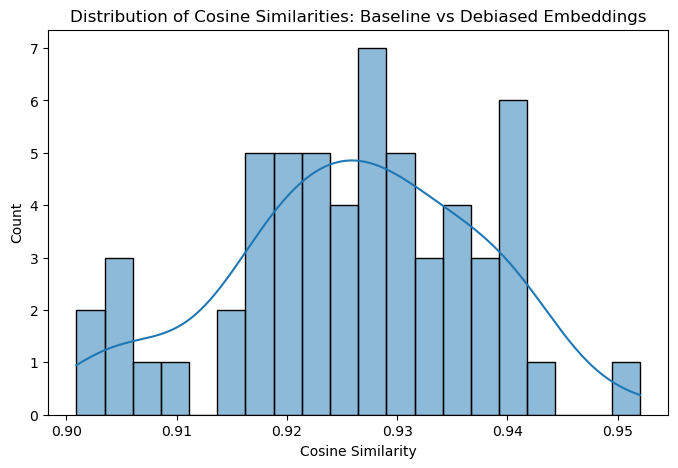

/var/folders/j8/zf_4c85j5plbmvlpz_x018h40000gn/T/ipykernel_6930/3263262923.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sim_df_sorted['Cosine_Similarity'], y=sim_df_sorted.index, palette="viridis")


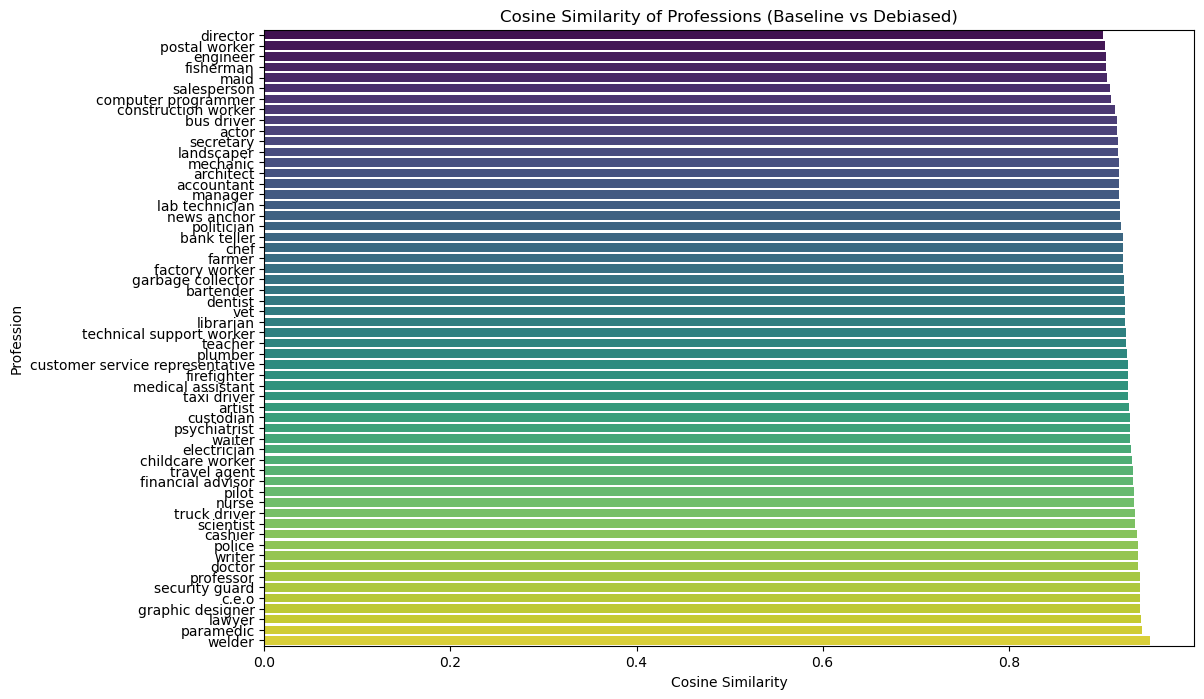

Top 5 professions with lowest cosine similarity (most changed):
               Cosine_Similarity
director                0.900911
postal worker           0.903395
engineer                0.904371
fisherman               0.904929
maid                    0.905300
Mean Cosine Similarity: 0.9260
Log Mean Cosine Similarity (natural log): -0.0769


In [88]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#loading the baseline and debiased embeddings
baseline_path = "profession_embeddings_baseline.csv"
debiased_path = "profession_embeddings_debiased_w=1_c=1.csv"

df_baseline = pd.read_csv(baseline_path)
df_debiased = pd.read_csv(debiased_path)

#ensuring the professions in both files match
common_professions = set(df_baseline['Profession']).intersection(set(df_debiased['Profession']))
print(f"Found {len(common_professions)} common professions")

cosine_similarities = {}

for prof in common_professions:
    base_vec = df_baseline.loc[df_baseline['Profession'] == prof].iloc[:, 1:].values
    debiased_vec = df_debiased.loc[df_debiased['Profession'] == prof].iloc[:, 1:].values
    
    #cosine_similarity shape (1, dim)
    cos_sim = cosine_similarity(base_vec, debiased_vec)[0][0]
    cosine_similarities[prof] = cos_sim

#converting to df for easier inspection and saving
sim_df = pd.DataFrame.from_dict(cosine_similarities, orient='index', columns=['Cosine_Similarity'])
sim_df = sim_df.sort_values('Cosine_Similarity')

print(sim_df)

#plotting

plt.figure(figsize=(8,5))
sns.histplot(sim_df['Cosine_Similarity'], bins=20, kde=True)
plt.title("Distribution of Cosine Similarities: Baseline vs Debiased Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,8))
sim_df_sorted = sim_df.sort_values('Cosine_Similarity')
sns.barplot(x=sim_df_sorted['Cosine_Similarity'], y=sim_df_sorted.index, palette="viridis")
plt.title("Cosine Similarity of Professions (Baseline vs Debiased)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Profession")
plt.show()

print("Top 5 professions with lowest cosine similarity (most changed):")
print(sim_df_sorted.head(5))

mean_cos_sim = sim_df['Cosine_Similarity'].mean()
print(f"Mean Cosine Similarity: {mean_cos_sim:.4f}")


log_mean_cos_sim = np.log(0.9260)
print(f"Log Mean Cosine Similarity (natural log): {log_mean_cos_sim:.4f}")



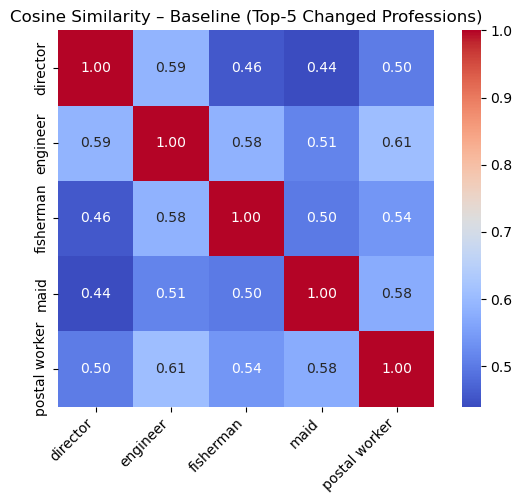

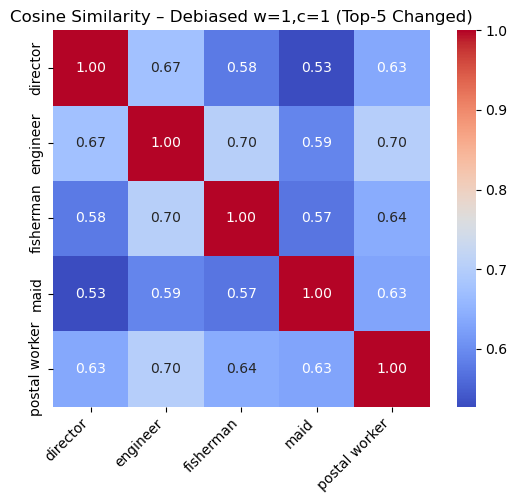

In [92]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

#embeddings
baseline_path = "profession_embeddings_baseline.csv"
debiased_path = "profession_embeddings_debiased_w=1_c=1.csv"

df_base = pd.read_csv(baseline_path)
df_debiased = pd.read_csv(debiased_path)

#lowercase professions for consistency
df_base['Profession'] = df_base['Profession'].str.lower()
df_debiased['Profession'] = df_debiased['Profession'].str.lower()

#only the most changed professions
target_profs = ["director", "postal worker", "engineer", "fisherman", "maid"]

df_base_sub = df_base[df_base['Profession'].isin(target_profs)].sort_values('Profession')
df_debiased_sub = df_debiased[df_debiased['Profession'].isin(target_profs)].sort_values('Profession')

#embeddings
base_emb = df_base_sub.iloc[:, 1:].values
debiased_emb = df_debiased_sub.iloc[:, 1:].values
labels = df_base_sub['Profession'].tolist()

#cosine similarity matrices
sim_base = cosine_similarity(base_emb)
sim_debiased = cosine_similarity(debiased_emb)

#plotting
def plot_heatmap(sim_matrix, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels, cmap='coolwarm', annot=True, fmt=".2f", square=True)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(sim_base, "Cosine Similarity – Baseline (Top-5 Changed Professions)")
plot_heatmap(sim_debiased, "Cosine Similarity – Debiased w=1,c=1 (Top-5 Changed)")



In [82]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#prepare baseline data
X, y = prepare_data(df_baseline, profession_to_category)

#split baseline into train and test
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#train classifier on baseline train set
clf = LogisticRegression(max_iter=1000)
clf.fit(X_base_train, y_base_train)

#test classifier on baseline test set (baseline accuracy)
y_pred_base = clf.predict(X_base_test)
acc_base = accuracy_score(y_base_test, y_pred_base)
print(f"Accuracy on baseline test set: {acc_base:.2f}")

#classification report
print(classification_report(y_base_test, y_pred_base))

#test classifier trained on baseline train on debiased embeddings
X_debiased, y_debiased = prepare_data(df_debiased, profession_to_category)

#predict categories on debiased embeddings
y_pred_debiased = clf.predict(X_debiased)
acc_debiased = accuracy_score(y_debiased, y_pred_debiased)
print(f"Accuracy on debiased embeddings: {acc_debiased:.2f}")

#classification report on debiased
print(classification_report(y_debiased, y_pred_debiased))


Accuracy on baseline test set: 0.73
              precision    recall  f1-score   support

    Business       1.00      1.00      1.00         1
    Creative       1.00      1.00      1.00         1
   Education       1.00      1.00      1.00         1
  Healthcare       1.00      1.00      1.00         2
Manual Labor       0.00      0.00      0.00         2
      Public       0.50      1.00      0.67         1
     Service       0.67      1.00      0.80         2
        Tech       0.00      0.00      0.00         1

    accuracy                           0.73        11
   macro avg       0.65      0.75      0.68        11
weighted avg       0.62      0.73      0.66        11

Accuracy on debiased embeddings: 0.91
              precision    recall  f1-score   support

    Business       0.83      1.00      0.91         5
    Creative       0.83      1.00      0.91         5
   Education       1.00      0.67      0.80         3
  Healthcare       1.00      1.00      1.00         8
Manu

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 58 common professions
                                 Cosine_Similarity
director                                  0.901299
engineer                                  0.902686
maid                                      0.907583
salesperson                               0.909630
computer programmer                       0.910971
fisherman                                 0.911476
postal worker                             0.912585
accountant                                0.912938
chef                                      0.917155
actor                                     0.917267
manager                                   0.917399
secretary                                 0.918232
construction worker                       0.918484
bus driver                                0.919105
lab technician                            0.919375
landscaper                                0.920602
architect                                 0.920637
librarian                                 0.921194
pol

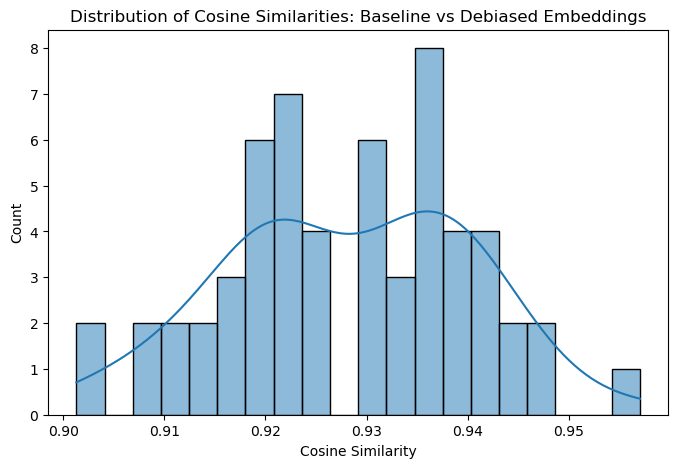

/var/folders/j8/zf_4c85j5plbmvlpz_x018h40000gn/T/ipykernel_6930/4202160282.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sim_df_sorted['Cosine_Similarity'], y=sim_df_sorted.index, palette="viridis")


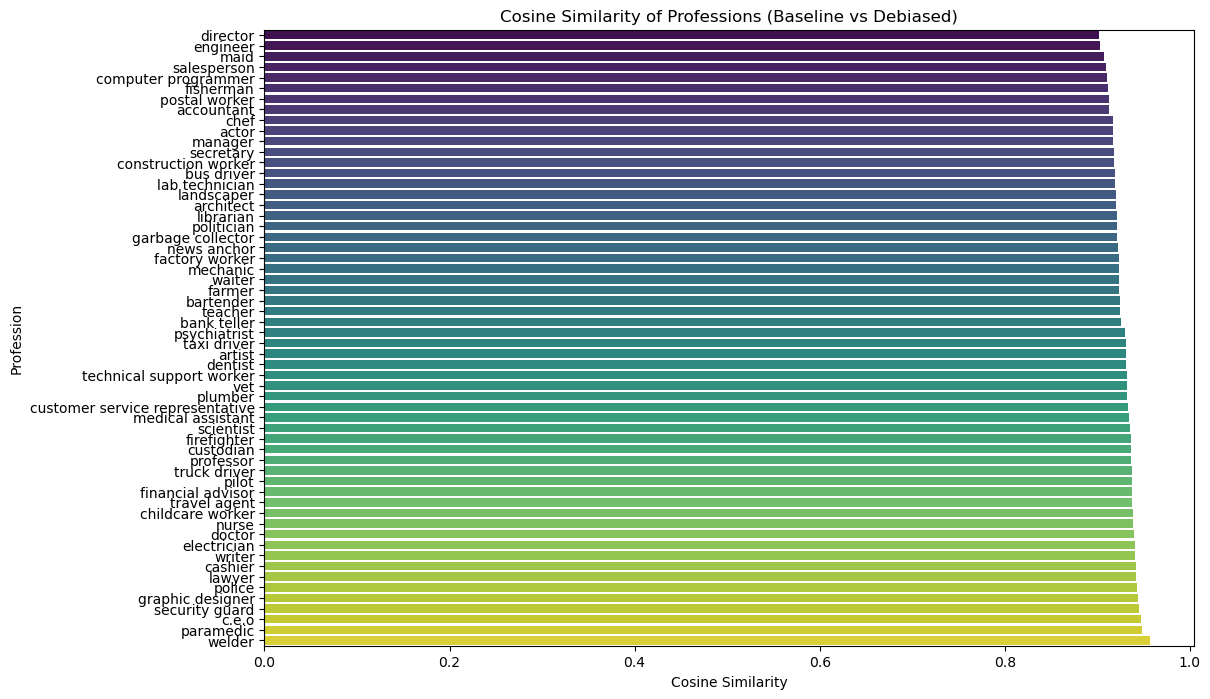

Top 5 professions with lowest cosine similarity (most changed):
                     Cosine_Similarity
director                      0.901299
engineer                      0.902686
maid                          0.907583
salesperson                   0.909630
computer programmer           0.910971
Mean Cosine Similarity: 0.9282
Log Mean Cosine Similarity (natural log): -0.0769


In [94]:
#loading the baseline and debiased embeddings csv
baseline_path = "profession_embeddings_baseline.csv"
debiased_path = "profession_embeddings_debiased_w=0_c=0.csv"

df_baseline = pd.read_csv(baseline_path)
df_debiased = pd.read_csv(debiased_path)

#ensuring the professions in both files match
common_professions = set(df_baseline['Profession']).intersection(set(df_debiased['Profession']))
print(f"Found {len(common_professions)} common professions")

cosine_similarities = {}

for prof in common_professions:
    base_vec = df_baseline.loc[df_baseline['Profession'] == prof].iloc[:, 1:].values
    debiased_vec = df_debiased.loc[df_debiased['Profession'] == prof].iloc[:, 1:].values
    
    #cosine_similarity=2d arrays
    cos_sim = cosine_similarity(base_vec, debiased_vec)[0][0]
    cosine_similarities[prof] = cos_sim

#convert to df for easier checks
sim_df = pd.DataFrame.from_dict(cosine_similarities, orient='index', columns=['Cosine_Similarity'])
sim_df = sim_df.sort_values('Cosine_Similarity')

print(sim_df)

#plotting

plt.figure(figsize=(8,5))
sns.histplot(sim_df['Cosine_Similarity'], bins=20, kde=True)
plt.title("Distribution of Cosine Similarities: Baseline vs Debiased Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,8))
sim_df_sorted = sim_df.sort_values('Cosine_Similarity')
sns.barplot(x=sim_df_sorted['Cosine_Similarity'], y=sim_df_sorted.index, palette="viridis")
plt.title("Cosine Similarity of Professions (Baseline vs Debiased)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Profession")
plt.show()

print("Top 5 professions with lowest cosine similarity (most changed):")
print(sim_df_sorted.head(5))

mean_cos_sim = sim_df['Cosine_Similarity'].mean()
print(f"Mean Cosine Similarity: {mean_cos_sim:.4f}")


log_mean_cos_sim = np.log(0.9260)
print(f"Log Mean Cosine Similarity (natural log): {log_mean_cos_sim:.4f}")


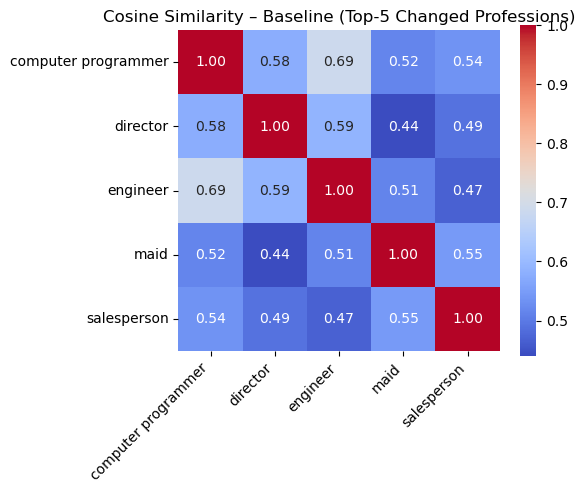

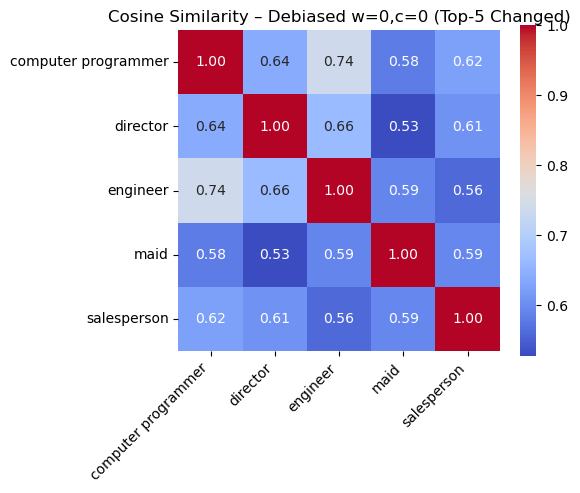

In [96]:
#embeddings
baseline_path = "profession_embeddings_baseline.csv"
debiased_path = "profession_embeddings_debiased_w=0_c=0.csv"

df_base = pd.read_csv(baseline_path)
df_debiased = pd.read_csv(debiased_path)

#lowercase professions for consistency
df_base['Profession'] = df_base['Profession'].str.lower()
df_debiased['Profession'] = df_debiased['Profession'].str.lower()

#only the most changed professions
target_profs = ["director", "salesperson", "engineer", "computer programmer", "maid"]

df_base_sub = df_base[df_base['Profession'].isin(target_profs)].sort_values('Profession')
df_debiased_sub = df_debiased[df_debiased['Profession'].isin(target_profs)].sort_values('Profession')

#embeddings
base_emb = df_base_sub.iloc[:, 1:].values
debiased_emb = df_debiased_sub.iloc[:, 1:].values
labels = df_base_sub['Profession'].tolist()

#cosine similarity matrices
sim_base = cosine_similarity(base_emb)
sim_debiased = cosine_similarity(debiased_emb)

#plotting
def plot_heatmap(sim_matrix, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels, cmap='coolwarm', annot=True, fmt=".2f", square=True)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(sim_base, "Cosine Similarity – Baseline (Top-5 Changed Professions)")
plot_heatmap(sim_debiased, "Cosine Similarity – Debiased w=0,c=0 (Top-5 Changed)")



In [65]:
#baseline data
X, y = prepare_data(df_baseline, profession_to_category)

#split baseline into train and test
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#training classifier on baseline train set
clf = LogisticRegression(max_iter=1000)
clf.fit(X_base_train, y_base_train)

#testing classifier on baseline test set=baseline accuracy
y_pred_base = clf.predict(X_base_test)
acc_base = accuracy_score(y_base_test, y_pred_base)
print(f"Accuracy on baseline test set: {acc_base:.2f}")

#detailed classification report
print(classification_report(y_base_test, y_pred_base))

#test classifier trained on baseline train on debiased embeddings
X_debiased, y_debiased = prepare_data(df_debiased, profession_to_category)

#predict categories on debiased emb.
y_pred_debiased = clf.predict(X_debiased)
acc_debiased = accuracy_score(y_debiased, y_pred_debiased)
print(f"Accuracy on debiased embeddings: {acc_debiased:.2f}")

#classification report
print(classification_report(y_debiased, y_pred_debiased))


Accuracy on baseline test set: 0.73
              precision    recall  f1-score   support

    Business       1.00      1.00      1.00         1
    Creative       1.00      1.00      1.00         1
   Education       1.00      1.00      1.00         1
  Healthcare       1.00      1.00      1.00         2
Manual Labor       0.00      0.00      0.00         2
      Public       0.50      1.00      0.67         1
     Service       0.67      1.00      0.80         2
        Tech       0.00      0.00      0.00         1

    accuracy                           0.73        11
   macro avg       0.65      0.75      0.68        11
weighted avg       0.62      0.73      0.66        11

Accuracy on debiased embeddings: 0.91
              precision    recall  f1-score   support

    Business       0.83      1.00      0.91         5
    Creative       1.00      1.00      1.00         5
   Education       1.00      0.67      0.80         3
  Healthcare       1.00      1.00      1.00         8
Manu

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 58 common professions
                                 Cosine_Similarity
director                                  0.910710
engineer                                  0.913037
maid                                      0.916719
salesperson                               0.918250
postal worker                             0.919713
computer programmer                       0.920764
accountant                                0.921358
fisherman                                 0.921429
landscaper                                0.922226
secretary                                 0.922823
manager                                   0.923981
architect                                 0.925713
bus driver                                0.926101
news anchor                               0.926879
mechanic                                  0.927140
lab technician                            0.927410
construction worker                       0.928346
politician                                0.928654
act

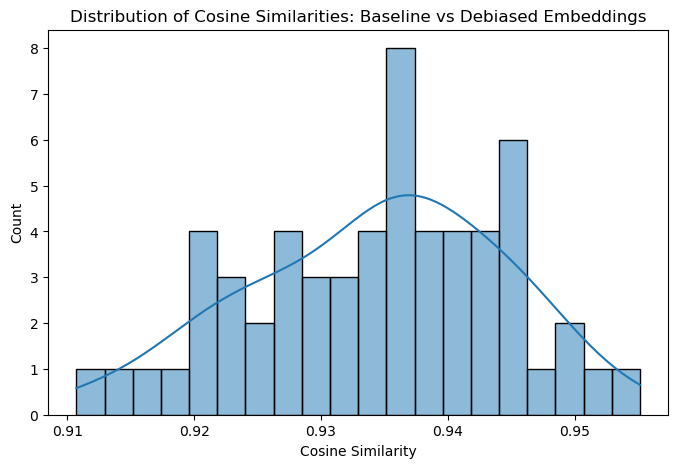

/var/folders/j8/zf_4c85j5plbmvlpz_x018h40000gn/T/ipykernel_6930/3938974616.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sim_df_sorted['Cosine_Similarity'], y=sim_df_sorted.index, palette="viridis")


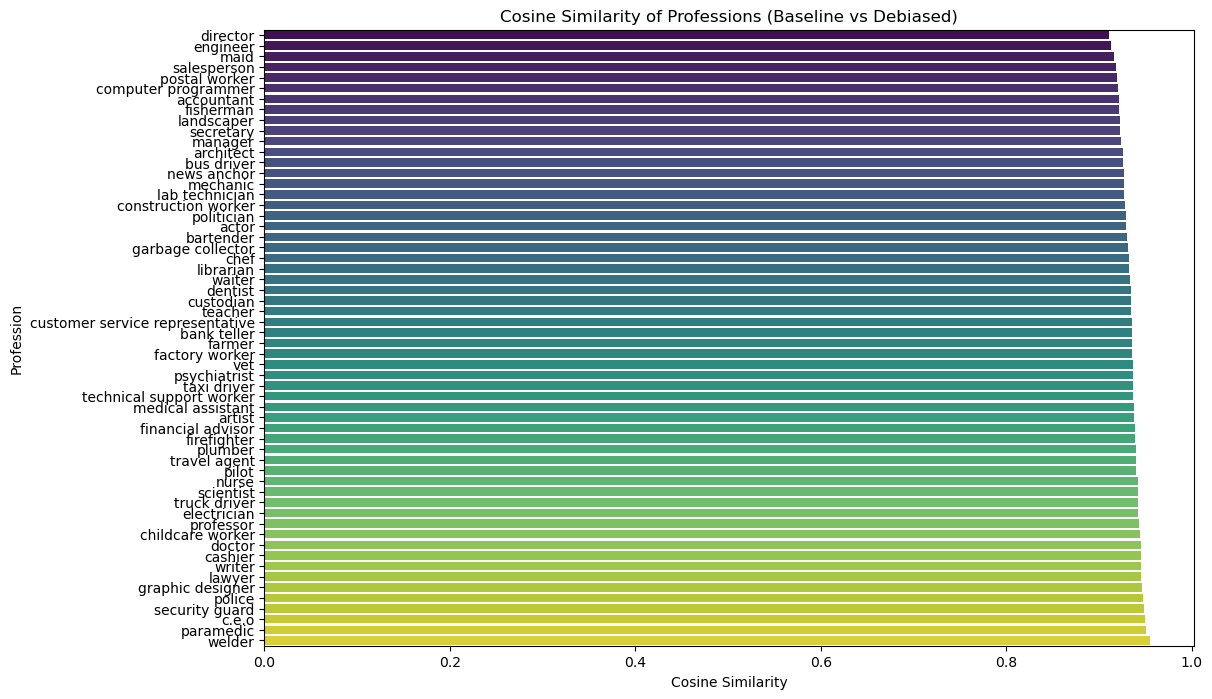

Top 5 professions with lowest cosine similarity (most changed):
               Cosine_Similarity
director                0.910710
engineer                0.913037
maid                    0.916719
salesperson             0.918250
postal worker           0.919713
Mean Cosine Similarity: 0.9343
Log Mean Cosine Similarity (natural log): -0.0769


In [98]:
#loading baseline and debiased embeddings
baseline_path = "profession_embeddings_baseline.csv"
debiased_path = "profession_embeddings_debiased_w=1_c=0.csv"

df_baseline = pd.read_csv(baseline_path)
df_debiased = pd.read_csv(debiased_path)

#ensuring the professions in both files are matching
common_professions = set(df_baseline['Profession']).intersection(set(df_debiased['Profession']))
print(f"Found {len(common_professions)} common professions")

cosine_similarities = {}

for prof in common_professions:
    base_vec = df_baseline.loc[df_baseline['Profession'] == prof].iloc[:, 1:].values
    debiased_vec = df_debiased.loc[df_debiased['Profession'] == prof].iloc[:, 1:].values
    
    #(1, dim)= shape
    cos_sim = cosine_similarity(base_vec, debiased_vec)[0][0]
    cosine_similarities[prof] = cos_sim

#convert to df for checks
sim_df = pd.DataFrame.from_dict(cosine_similarities, orient='index', columns=['Cosine_Similarity'])
sim_df = sim_df.sort_values('Cosine_Similarity')

print(sim_df)

#plotting

plt.figure(figsize=(8,5))
sns.histplot(sim_df['Cosine_Similarity'], bins=20, kde=True)
plt.title("Distribution of Cosine Similarities: Baseline vs Debiased Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,8))
sim_df_sorted = sim_df.sort_values('Cosine_Similarity')
sns.barplot(x=sim_df_sorted['Cosine_Similarity'], y=sim_df_sorted.index, palette="viridis")
plt.title("Cosine Similarity of Professions (Baseline vs Debiased)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Profession")
plt.show()

print("Top 5 professions with lowest cosine similarity (most changed):")
print(sim_df_sorted.head(5))


mean_cos_sim = sim_df['Cosine_Similarity'].mean()
print(f"Mean Cosine Similarity: {mean_cos_sim:.4f}")


log_mean_cos_sim = np.log(0.9260)
print(f"Log Mean Cosine Similarity (natural log): {log_mean_cos_sim:.4f}")


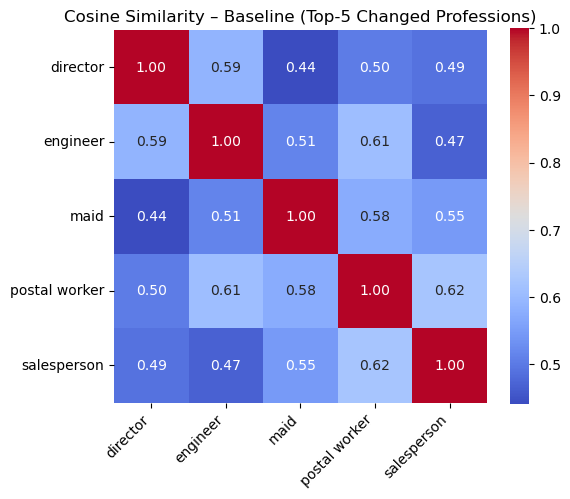

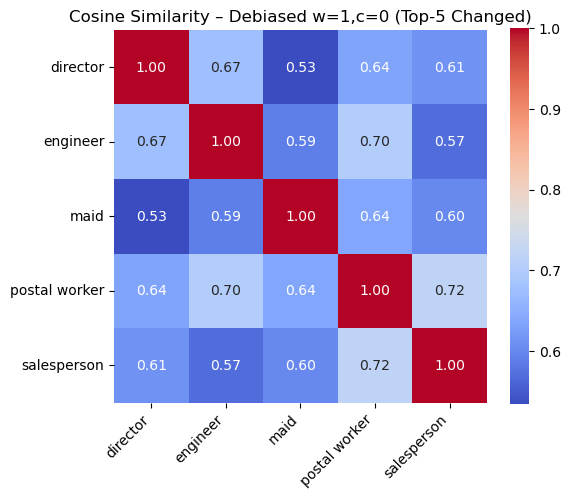

In [102]:
#embeddings
baseline_path = "profession_embeddings_baseline.csv"
debiased_path = "profession_embeddings_debiased_w=1_c=0.csv"

df_base = pd.read_csv(baseline_path)
df_debiased = pd.read_csv(debiased_path)

#lowercaseing professions for consistency
df_base['Profession'] = df_base['Profession'].str.lower()
df_debiased['Profession'] = df_debiased['Profession'].str.lower()

#only the most changed professions
target_profs = ["director", "postal worker", "engineer", "salesperson", "maid"]

df_base_sub = df_base[df_base['Profession'].isin(target_profs)].sort_values('Profession')
df_debiased_sub = df_debiased[df_debiased['Profession'].isin(target_profs)].sort_values('Profession')

#embeddings
base_emb = df_base_sub.iloc[:, 1:].values
debiased_emb = df_debiased_sub.iloc[:, 1:].values
labels = df_base_sub['Profession'].tolist()

#cosine similarity matrices
sim_base = cosine_similarity(base_emb)
sim_debiased = cosine_similarity(debiased_emb)

#plotting
def plot_heatmap(sim_matrix, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels, cmap='coolwarm', annot=True, fmt=".2f", square=True)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(sim_base, "Cosine Similarity – Baseline (Top-5 Changed Professions)")
plot_heatmap(sim_debiased, "Cosine Similarity – Debiased w=1,c=0 (Top-5 Changed)")



In [69]:
#prepare baseline data
X, y = prepare_data(df_baseline, profession_to_category)

#split baseline into train and test
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#train classifier on baseline train set
clf = LogisticRegression(max_iter=1000)
clf.fit(X_base_train, y_base_train)

#test classifier on baseline test set=baseline accuracy
y_pred_base = clf.predict(X_base_test)
acc_base = accuracy_score(y_base_test, y_pred_base)
print(f"Accuracy on baseline test set: {acc_base:.2f}")

#classification report
print(classification_report(y_base_test, y_pred_base))

#test classifier trained on baseline train on debiased embeddings
X_debiased, y_debiased = prepare_data(df_debiased, profession_to_category)

#predict categories on debiased emb.
y_pred_debiased = clf.predict(X_debiased)
acc_debiased = accuracy_score(y_debiased, y_pred_debiased)
print(f"Accuracy on debiased embeddings: {acc_debiased:.2f}")

#classification report on debiased
print(classification_report(y_debiased, y_pred_debiased))


Accuracy on baseline test set: 0.73
              precision    recall  f1-score   support

    Business       1.00      1.00      1.00         1
    Creative       1.00      1.00      1.00         1
   Education       1.00      1.00      1.00         1
  Healthcare       1.00      1.00      1.00         2
Manual Labor       0.00      0.00      0.00         2
      Public       0.50      1.00      0.67         1
     Service       0.67      1.00      0.80         2
        Tech       0.00      0.00      0.00         1

    accuracy                           0.73        11
   macro avg       0.65      0.75      0.68        11
weighted avg       0.62      0.73      0.66        11

Accuracy on debiased embeddings: 0.91
              precision    recall  f1-score   support

    Business       0.83      1.00      0.91         5
    Creative       0.83      1.00      0.91         5
   Education       1.00      0.67      0.80         3
  Healthcare       1.00      1.00      1.00         8
Manu

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 58 common professions
                                 Cosine_Similarity
postal worker                             0.898770
engineer                                  0.901683
maid                                      0.902441
salesperson                               0.904412
director                                  0.904654
fisherman                                 0.905245
mechanic                                  0.908760
computer programmer                       0.910796
construction worker                       0.911306
bus driver                                0.911824
waiter                                    0.913956
secretary                                 0.914016
accountant                                0.915498
architect                                 0.916363
farmer                                    0.916908
manager                                   0.917350
lab technician                            0.918025
garbage collector                         0.918430
bar

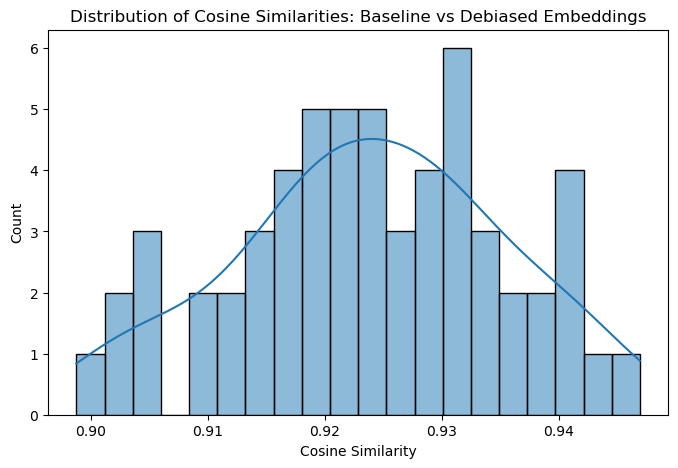

/var/folders/j8/zf_4c85j5plbmvlpz_x018h40000gn/T/ipykernel_6930/2599599871.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sim_df_sorted['Cosine_Similarity'], y=sim_df_sorted.index, palette="viridis")


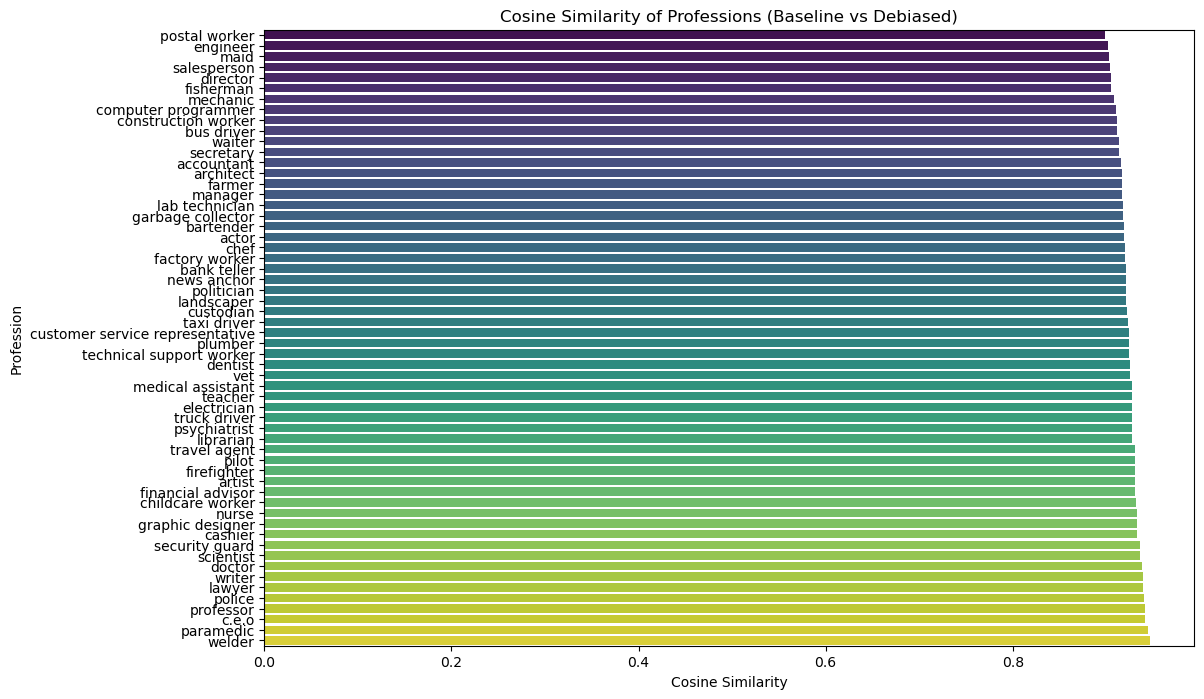

Top 5 professions with lowest cosine similarity (most changed):
               Cosine_Similarity
postal worker           0.898770
engineer                0.901683
maid                    0.902441
salesperson             0.904412
director                0.904654
Mean Cosine Similarity: 0.9238


In [71]:
#loading baseline and debiased embeddings
baseline_path = "profession_embeddings_baseline.csv"
debiased_path = "profession_embeddings_debiased_w=0_c=1.csv"

df_baseline = pd.read_csv(baseline_path)
df_debiased = pd.read_csv(debiased_path)

#ensuring the professions in both files matching
common_professions = set(df_baseline['Profession']).intersection(set(df_debiased['Profession']))
print(f"Found {len(common_professions)} common professions")

cosine_similarities = {}

for prof in common_professions:
    base_vec = df_baseline.loc[df_baseline['Profession'] == prof].iloc[:, 1:].values
    debiased_vec = df_debiased.loc[df_debiased['Profession'] == prof].iloc[:, 1:].values
    
    #2d arrays
    cos_sim = cosine_similarity(base_vec, debiased_vec)[0][0]
    cosine_similarities[prof] = cos_sim

#converting to df for checkiing
sim_df = pd.DataFrame.from_dict(cosine_similarities, orient='index', columns=['Cosine_Similarity'])
sim_df = sim_df.sort_values('Cosine_Similarity')

print(sim_df)

#plotting
plt.figure(figsize=(8,5))
sns.histplot(sim_df['Cosine_Similarity'], bins=20, kde=True)
plt.title("Distribution of Cosine Similarities: Baseline vs Debiased Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,8))
sim_df_sorted = sim_df.sort_values('Cosine_Similarity')
sns.barplot(x=sim_df_sorted['Cosine_Similarity'], y=sim_df_sorted.index, palette="viridis")
plt.title("Cosine Similarity of Professions (Baseline vs Debiased)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Profession")
plt.show()

print("Top 5 professions with lowest cosine similarity (most changed):")
print(sim_df_sorted.head(5))

mean_cos_sim = sim_df['Cosine_Similarity'].mean()
print(f"Mean Cosine Similarity: {mean_cos_sim:.4f}")


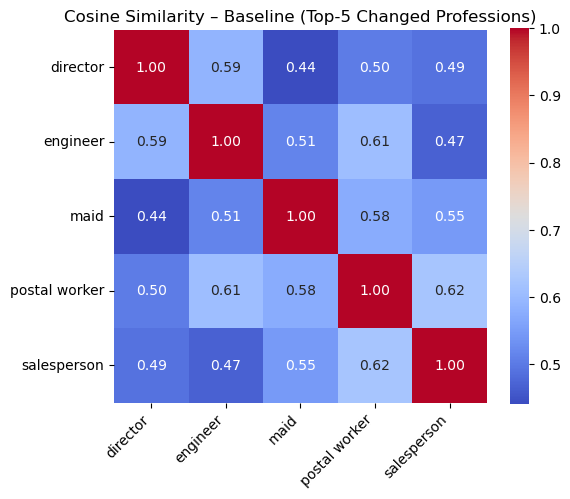

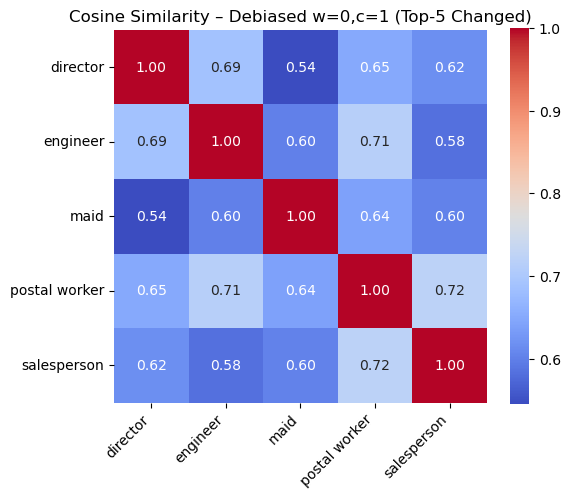

In [104]:
#embeddings
baseline_path = "profession_embeddings_baseline.csv"
debiased_path = "profession_embeddings_debiased_w=0_c=1.csv"

df_base = pd.read_csv(baseline_path)
df_debiased = pd.read_csv(debiased_path)

#lowercase professions for consistency
df_base['Profession'] = df_base['Profession'].str.lower()
df_debiased['Profession'] = df_debiased['Profession'].str.lower()

#only the most changed professions
target_profs = ["director", "postal worker", "engineer", "salesperson", "maid"]

df_base_sub = df_base[df_base['Profession'].isin(target_profs)].sort_values('Profession')
df_debiased_sub = df_debiased[df_debiased['Profession'].isin(target_profs)].sort_values('Profession')

#embeddings
base_emb = df_base_sub.iloc[:, 1:].values
debiased_emb = df_debiased_sub.iloc[:, 1:].values
labels = df_base_sub['Profession'].tolist()

#cosine similarity matrices
sim_base = cosine_similarity(base_emb)
sim_debiased = cosine_similarity(debiased_emb)

#plotting
def plot_heatmap(sim_matrix, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels, cmap='coolwarm', annot=True, fmt=".2f", square=True)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(sim_base, "Cosine Similarity – Baseline (Top-5 Changed Professions)")
plot_heatmap(sim_debiased, "Cosine Similarity – Debiased w=0,c=1 (Top-5 Changed)")



In [73]:
#prepare baseline data
X, y = prepare_data(df_baseline, profession_to_category)

#split baseline into train and test
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#train classifier on baseline train set
clf = LogisticRegression(max_iter=1000)
clf.fit(X_base_train, y_base_train)

#test classifier on baseline test set (baseline accuracy)
y_pred_base = clf.predict(X_base_test)
acc_base = accuracy_score(y_base_test, y_pred_base)
print(f"Accuracy on baseline test set: {acc_base:.2f}")

#detailed classification report
print(classification_report(y_base_test, y_pred_base))

#test classifier trained on baseline train on debiased embeddings
X_debiased, y_debiased = prepare_data(df_debiased, profession_to_category)

#predict categories on debiased embeddings
y_pred_debiased = clf.predict(X_debiased)
acc_debiased = accuracy_score(y_debiased, y_pred_debiased)
print(f"Accuracy on debiased embeddings: {acc_debiased:.2f}")

#classification report
print(classification_report(y_debiased, y_pred_debiased))


Accuracy on baseline test set: 0.73
              precision    recall  f1-score   support

    Business       1.00      1.00      1.00         1
    Creative       1.00      1.00      1.00         1
   Education       1.00      1.00      1.00         1
  Healthcare       1.00      1.00      1.00         2
Manual Labor       0.00      0.00      0.00         2
      Public       0.50      1.00      0.67         1
     Service       0.67      1.00      0.80         2
        Tech       0.00      0.00      0.00         1

    accuracy                           0.73        11
   macro avg       0.65      0.75      0.68        11
weighted avg       0.62      0.73      0.66        11

Accuracy on debiased embeddings: 0.89
              precision    recall  f1-score   support

    Business       0.83      1.00      0.91         5
    Creative       1.00      1.00      1.00         5
   Education       1.00      0.67      0.80         3
  Healthcare       1.00      1.00      1.00         8
Manu

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 58 common professions
                                 Cosine_Similarity
engineer                                  0.903783
director                                  0.905547
maid                                      0.908731
postal worker                             0.909388
fisherman                                 0.910540
salesperson                               0.911423
accountant                                0.913775
computer programmer                       0.914663
lab technician                            0.917422
actor                                     0.918028
waiter                                    0.918196
construction worker                       0.918324
architect                                 0.918394
chef                                      0.919397
manager                                   0.920187
librarian                                 0.920287
bus driver                                0.920624
mechanic                                  0.921750
sec

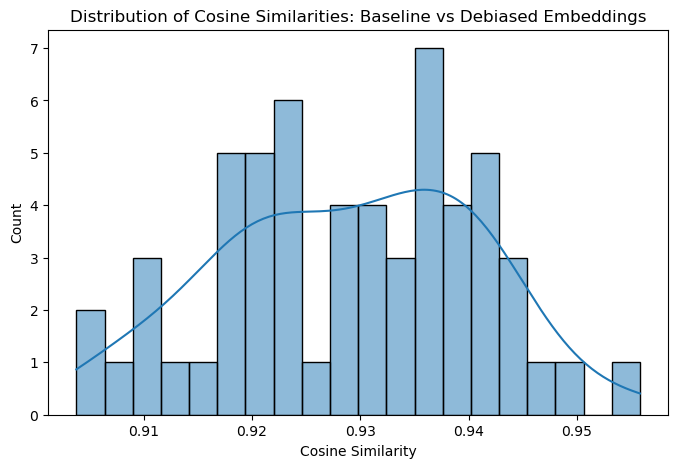

/var/folders/j8/zf_4c85j5plbmvlpz_x018h40000gn/T/ipykernel_6930/757154940.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sim_df_sorted['Cosine_Similarity'], y=sim_df_sorted.index, palette="viridis")


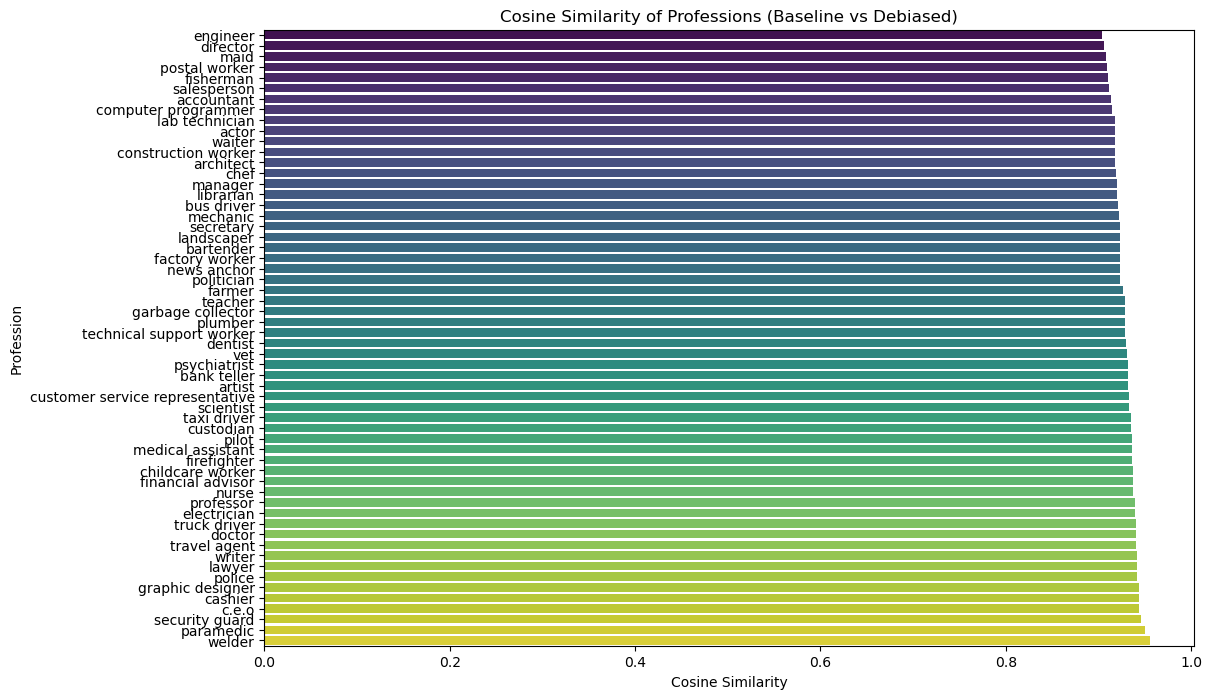

Top 5 professions with lowest cosine similarity (most changed):
               Cosine_Similarity
engineer                0.903783
director                0.905547
maid                    0.908731
postal worker           0.909388
fisherman               0.910540
Mean Cosine Similarity: 0.9289


In [84]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#load the baseline and debiased embeddings csv
baseline_path = "profession_embeddings_baseline.csv"
debiased_path = "profession_embeddings_debiased_w=0.5_c=0.5.csv"

df_baseline = pd.read_csv(baseline_path)
df_debiased = pd.read_csv(debiased_path)

#ensuring the professions in both files match
common_professions = set(df_baseline['Profession']).intersection(set(df_debiased['Profession']))
print(f"Found {len(common_professions)} common professions")

cosine_similarities = {}

for prof in common_professions:
    base_vec = df_baseline.loc[df_baseline['Profession'] == prof].iloc[:, 1:].values
    debiased_vec = df_debiased.loc[df_debiased['Profession'] == prof].iloc[:, 1:].values
    
    cos_sim = cosine_similarity(base_vec, debiased_vec)[0][0]
    cosine_similarities[prof] = cos_sim

#convert to df for easier inspect
sim_df = pd.DataFrame.from_dict(cosine_similarities, orient='index', columns=['Cosine_Similarity'])
sim_df = sim_df.sort_values('Cosine_Similarity')

print(sim_df)

#plotting
plt.figure(figsize=(8,5))
sns.histplot(sim_df['Cosine_Similarity'], bins=20, kde=True)
plt.title("Distribution of Cosine Similarities: Baseline vs Debiased Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,8))
sim_df_sorted = sim_df.sort_values('Cosine_Similarity')
sns.barplot(x=sim_df_sorted['Cosine_Similarity'], y=sim_df_sorted.index, palette="viridis")
plt.title("Cosine Similarity of Professions (Baseline vs Debiased)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Profession")
plt.show()

print("Top 5 professions with lowest cosine similarity (most changed):")
print(sim_df_sorted.head(5))

mean_cos_sim = sim_df['Cosine_Similarity'].mean()
print(f"Mean Cosine Similarity: {mean_cos_sim:.4f}")


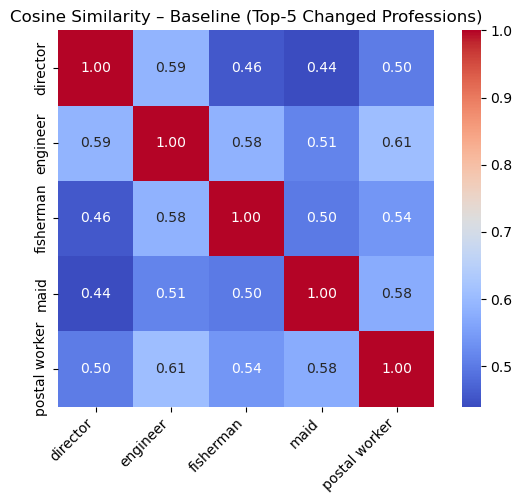

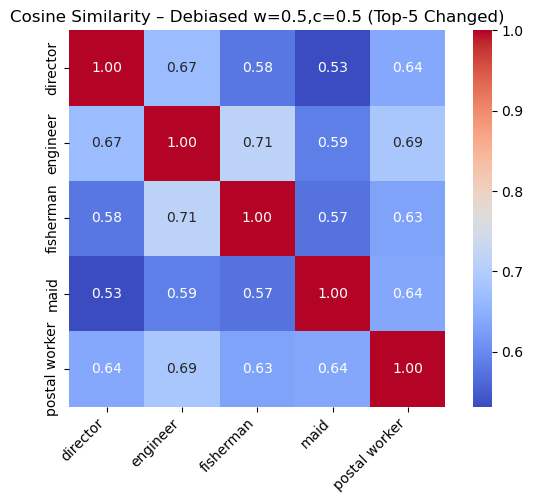

In [106]:
#embeddings
baseline_path = "profession_embeddings_baseline.csv"
debiased_path = "profession_embeddings_debiased_w=0.5_c=0.5.csv"

df_base = pd.read_csv(baseline_path)
df_debiased = pd.read_csv(debiased_path)

#lowercase professions for consistency
df_base['Profession'] = df_base['Profession'].str.lower()
df_debiased['Profession'] = df_debiased['Profession'].str.lower()

#only the most changed professions
target_profs = ["director", "postal worker", "engineer", "fisherman", "maid"]

df_base_sub = df_base[df_base['Profession'].isin(target_profs)].sort_values('Profession')
df_debiased_sub = df_debiased[df_debiased['Profession'].isin(target_profs)].sort_values('Profession')

#embeddings
base_emb = df_base_sub.iloc[:, 1:].values
debiased_emb = df_debiased_sub.iloc[:, 1:].values
labels = df_base_sub['Profession'].tolist()

#cosine similarity matrices
sim_base = cosine_similarity(base_emb)
sim_debiased = cosine_similarity(debiased_emb)

#plotting
def plot_heatmap(sim_matrix, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels, cmap='coolwarm', annot=True, fmt=".2f", square=True)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(sim_base, "Cosine Similarity – Baseline (Top-5 Changed Professions)")
plot_heatmap(sim_debiased, "Cosine Similarity – Debiased w=0.5,c=0.5 (Top-5 Changed)")



In [86]:
#baseline data
X, y = prepare_data(df_baseline, profession_to_category)

#split baseline into train and test
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#train classifier on baseline train set
clf = LogisticRegression(max_iter=1000)
clf.fit(X_base_train, y_base_train)

#test classifier on baseline test set (baseline accuracy)
y_pred_base = clf.predict(X_base_test)
acc_base = accuracy_score(y_base_test, y_pred_base)
print(f"Accuracy on baseline test set: {acc_base:.2f}")

#classification report
print(classification_report(y_base_test, y_pred_base))

#test classifier trained on baseline train on debiased emb.
X_debiased, y_debiased = prepare_data(df_debiased, profession_to_category)

#predict categories on debiased emb.
y_pred_debiased = clf.predict(X_debiased)
acc_debiased = accuracy_score(y_debiased, y_pred_debiased)
print(f"Accuracy on debiased embeddings: {acc_debiased:.2f}")

#classification report on debiased
print(classification_report(y_debiased, y_pred_debiased))


Accuracy on baseline test set: 0.73
              precision    recall  f1-score   support

    Business       1.00      1.00      1.00         1
    Creative       1.00      1.00      1.00         1
   Education       1.00      1.00      1.00         1
  Healthcare       1.00      1.00      1.00         2
Manual Labor       0.00      0.00      0.00         2
      Public       0.50      1.00      0.67         1
     Service       0.67      1.00      0.80         2
        Tech       0.00      0.00      0.00         1

    accuracy                           0.73        11
   macro avg       0.65      0.75      0.68        11
weighted avg       0.62      0.73      0.66        11

Accuracy on debiased embeddings: 0.91
              precision    recall  f1-score   support

    Business       0.83      1.00      0.91         5
    Creative       0.83      1.00      0.91         5
   Education       1.00      0.67      0.80         3
  Healthcare       1.00      1.00      1.00         8
Manu

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
####SIGNIFICANCE TESTS:
####BASELINE
from scipy.stats import ttest_ind
import pandas as pd
data_baseline = {
    "profession": [
        "paramedic", "politician", "medical assistant", "dentist", "nurse", "doctor", "vet", "professor",
        "artist", "librarian", "teacher", "writer", "psychiatrist", "actor", "firefighter", "police",
        "childcare worker", "scientist", "director", "c.e.o", "travel agent", "pilot", "architect",
        "bus driver", "farmer", "taxi driver", "secretary", "maid", "lawyer", "lab technician", "chef",
        "postal worker", "fisherman", "mechanic", "manager", "landscaper", "graphic designer", "engineer",
        "custodian", "accountant", "salesperson", "financial advisor", "waiter", "security guard", "cashier",
        "news anchor", "electrician", "bank teller", "customer service representative", "plumber",
        "truck driver", "garbage collector", "computer programmer", "technical support worker", "welder",
        "bartender", "construction worker", "factory worker"
    ],
    "warmth_cos": [
        0.0182, -0.0962, -0.0995, -0.1043, -0.1078, -0.1089, -0.1116, -0.1165, -0.1165, -0.1178, -0.1178,
        -0.1196, -0.1225, -0.1230, -0.1272, -0.1287, -0.1349, -0.1400, -0.1410, -0.1425, -0.1427, -0.1515,
        -0.1534, -0.1534, -0.1536, -0.1536, -0.1551, -0.1580, -0.1589, -0.1606, -0.1614, -0.1640, -0.1667,
        -0.1677, -0.1688, -0.1700, -0.1703, -0.1712, -0.1715, -0.1739, -0.1739, -0.1778, -0.1789, -0.1794,
        -0.1811, -0.1816, -0.1820, -0.1837, -0.1838, -0.1843, -0.1876, -0.1879, -0.1881, -0.1884, -0.1927,
        -0.2032, -0.2076, -0.2119
    ],
    "competence_cos": [
        -0.2149, -0.0682, -0.1477, -0.1078, -0.1063, -0.0406, -0.1151, -0.0245, -0.0771, -0.0964, -0.0782,
        -0.0712, -0.0649, -0.0742, -0.1924, -0.1065, -0.2173, -0.0570, -0.0743, -0.0937, -0.1569, -0.1044,
        -0.1176, -0.1871, -0.1450, -0.1985, -0.0832, -0.1203, -0.0625, -0.1654, -0.1079, -0.2030, -0.1341,
        -0.1676, -0.1244, -0.1497, -0.1449, -0.1044, -0.1673, -0.1335, -0.2133, -0.1494, -0.1415, -0.2119,
        -0.2129, -0.0515, -0.2134, -0.1959, -0.2255, -0.2287, -0.1738, -0.2277, -0.1311, -0.2408, -0.1736,
        -0.1578, -0.2212, -0.1984
    ]
}

df = pd.DataFrame(data_baseline)

#group definitions
professions_competence = [
    "c.e.o", "lawyer", "accountant", "professor", "vet", "paramedic", "chef", "dentist",
    "doctor", "nurse", "scientist", "welder", "mechanic", "psychiatrist", "pilot",
    "director", "architect", "writer", "manager", "engineer", "actor", "lab technician",
    "news anchor", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "computer programmer", "construction worker"
]

professions_non_competence = [
    'artist', 'bank teller', 'bartender', 'bus driver', 'cashier', 'childcare worker', 'custodian', 'customer service representative',
    'factory worker', 'farmer', 'firefighter', 'fisherman', 'garbage collector', 'landscaper', 'librarian', 'maid',
    'medical assistant', 'musician', 'plumber', 'police', 'politician', 'postal worker', 'salesperson', 'security guard',
    'secretary', 'taxi driver', 'teacher', 'truck driver', 'waiter'
]

professions_warm = [
    "professor", "vet", "paramedic", "chef", "dentist", "doctor", "nurse", "teacher", "secretary",
    "psychiatrist", "farmer", "pilot", "architect", "writer","medical assistant", "engineer", "bartender", "firefighter","lab technician",
    "custodian", "childcare worker", "bank teller"
]

professions_nonwarm = [
    'accountant', 'actor', 'artist', 'bus driver', 'cashier', 'c.e.o.', 'computer programmer', 'construction worker',
    'customer service representative', 'director', 'electrician', 'factory worker', 'financial advisor', 'fisherman',
    'garbage collector', 'graphic designer', 'landscaper', 'lawyer', 'librarian', 'maid', 'manager', 'mechanic',
    'musician', 'news anchor', 'police', 'politician', 'postal worker', 'salesperson', 'scientist', 'security guard',
    'technical support worker', 'truck driver', 'waiter', 'welder'
]


#warmth test
warm = df[df['profession'].isin(professions_warm)]['warmth_cos']
nonwarm = df[df['profession'].isin(professions_nonwarm)]['warmth_cos']
t_warm, p_warm = ttest_ind(warm, nonwarm, equal_var=False)

#competence test
competent = df[df['profession'].isin(professions_competence)]['competence_cos']
noncompetent = df[df['profession'].isin(professions_non_competence)]['competence_cos']
t_comp, p_comp = ttest_ind(competent, noncompetent, equal_var=False)

#results
print(f"Warmth t-test: t = {t_warm:.4f}, p = {p_warm:.4f}")
print(f"Competence t-test: t = {t_comp:.4f}, p = {p_comp:.4f}")



Warmth t-test: t = 3.1772, p = 0.0033
Competence t-test: t = 3.0443, p = 0.0036


In [45]:
#w=0, c=1

data_w_0_c_1 = {
    "profession": [
        "paramedic", "doctor", "nurse", "dentist", "vet", "teacher", "psychiatrist",
        "medical assistant", "professor", "police", "librarian", "artist", "writer",
        "politician", "actor", "scientist", "firefighter", "lawyer", "pilot", "director",
        "maid", "c.e.o", "chef", "waiter", "architect", "fisherman", "secretary",
        "travel agent", "manager", "engineer", "mechanic", "childcare worker", "taxi driver",
        "farmer", "lab technician", "news anchor", "bus driver", "accountant",
        "graphic designer", "bartender", "postal worker", "custodian", "security guard",
        "cashier", "bank teller", "welder", "salesperson", "landscaper",
        "electrician", "customer service representative", "financial advisor", "truck driver",
        "technical support worker", "plumber", "computer programmer", "garbage collector",
        "construction worker", "factory worker"
    ],
    "warmth_cos": [
        -0.0517, -0.1232, -0.1288, -0.1325, -0.1337, -0.1338, -0.1347,
        -0.1357, -0.1372, -0.1399, -0.1466, -0.1500, -0.1522,
        -0.1526, -0.1530, -0.1534, -0.1601, -0.1644, -0.1659, -0.1667,
        -0.1673, -0.1685, -0.1694, -0.1726, -0.1732, -0.1755, -0.1756,
        -0.1763, -0.1793, -0.1794, -0.1797, -0.1798, -0.1800,
        -0.1817, -0.1818, -0.1849, -0.1864, -0.1880,
        -0.1895, -0.1907, -0.1946, -0.1953, -0.1955,
        -0.1970, -0.1971, -0.2008, -0.2021, -0.2023,
        -0.2026, -0.2051, -0.2051, -0.2059,
        -0.2102, -0.2102, -0.2107, -0.2116,
        -0.2179, -0.2289
    ],
    "competence_cos": [
        -0.1548, -0.0136, -0.0552, -0.0560, -0.0513, -0.0372, -0.0230,
        -0.0772, 0.0107, -0.0541, -0.0452, -0.0296, -0.0199,
        -0.0344, -0.0215, -0.0188, -0.1182, -0.0354, -0.0590, -0.0169,
        -0.0725, -0.0524, -0.0538, -0.0861, -0.0618, -0.0735, -0.0380,
        -0.0953, -0.0593, -0.0550, -0.0957, -0.1331, -0.1284,
        -0.0780, -0.0947, -0.0072, -0.1147, -0.0745,
        -0.0931, -0.0915, -0.1166, -0.1026, -0.1397,
        -0.1371, -0.1183, -0.1284, -0.1240, -0.0937,
        -0.1392, -0.1406, -0.0767, -0.1099,
        -0.1570, -0.1429, -0.0807, -0.1495,
        -0.1417, -0.1246
    ]
}

df = pd.DataFrame(data_w_0_c_1)

#group definitions
professions_competence = [
    "c.e.o", "lawyer", "accountant", "professor", "vet", "paramedic", "chef", "dentist",
    "doctor", "nurse", "scientist", "welder", "mechanic", "psychiatrist", "pilot",
    "director", "architect", "writer", "manager", "engineer", "actor", "lab technician",
    "news anchor", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "computer programmer", "construction worker"
]

professions_non_competence = [
    'artist', 'bank teller', 'bartender', 'bus driver', 'cashier', 'childcare worker', 'custodian', 'customer service representative',
    'factory worker', 'farmer', 'firefighter', 'fisherman', 'garbage collector', 'landscaper', 'librarian', 'maid',
    'medical assistant', 'musician', 'plumber', 'police', 'politician', 'postal worker', 'salesperson', 'security guard',
    'secretary', 'taxi driver', 'teacher', 'truck driver', 'waiter'
]

professions_warm = [
    "professor", "vet", "paramedic", "chef", "dentist", "doctor", "nurse", "teacher", "secretary",
    "psychiatrist", "farmer", "pilot", "architect", "writer","medical assistant", "engineer", "bartender", "firefighter","lab technician",
    "custodian", "childcare worker", "bank teller"
]

professions_nonwarm = [
    'accountant', 'actor', 'artist', 'bus driver', 'cashier', 'c.e.o.', 'computer programmer', 'construction worker',
    'customer service representative', 'director', 'electrician', 'factory worker', 'financial advisor', 'fisherman',
    'garbage collector', 'graphic designer', 'landscaper', 'lawyer', 'librarian', 'maid', 'manager', 'mechanic',
    'musician', 'news anchor', 'police', 'politician', 'postal worker', 'salesperson', 'scientist', 'security guard',
    'technical support worker', 'truck driver', 'waiter', 'welder'
]


#warmth test
warm = df[df['profession'].isin(professions_warm)]['warmth_cos']
nonwarm = df[df['profession'].isin(professions_nonwarm)]['warmth_cos']
t_warm, p_warm = ttest_ind(warm, nonwarm, equal_var=False)

#competence test
competent = df[df['profession'].isin(professions_competence)]['competence_cos']
noncompetent = df[df['profession'].isin(professions_non_competence)]['competence_cos']
t_comp, p_comp = ttest_ind(competent, noncompetent, equal_var=False)

#results
print(f"Warmth t-test: t = {t_warm:.4f}, p = {p_warm:.4f}")
print(f"Competence t-test: t = {t_comp:.4f}, p = {p_comp:.4f}")


Warmth t-test: t = 3.7074, p = 0.0007
Competence t-test: t = 2.8759, p = 0.0058


In [47]:
#w=0, c-=0
import pandas as pd

data_w_0_c_0 = {
    "profession": [
        "paramedic", "doctor", "nurse", "dentist", "vet", "psychiatrist", "teacher",
        "medical assistant", "police", "professor", "librarian", "writer", "scientist",
        "artist", "politician", "actor", "firefighter", "pilot", "lawyer", "maid",
        "c.e.o", "director", "chef", "waiter", "fisherman", "architect", "travel agent",
        "childcare worker", "mechanic", "taxi driver", "engineer", "manager", "secretary",
        "lab technician", "farmer", "bus driver", "accountant", "news anchor",
        "graphic designer", "bartender", "postal worker", "security guard", "bank teller",
        "cashier", "custodian", "salesperson", "welder", "electrician", "landscaper",
        "customer service representative", "truck driver", "financial advisor", "plumber",
        "garbage collector", "technical support worker", "computer programmer",
        "construction worker", "factory worker"
    ],
    "warmth_cos": [
        -0.0439, -0.1164, -0.1223, -0.1280, -0.1282, -0.1291, -0.1302,
        -0.1316, -0.1346, -0.1356, -0.1453, -0.1478, -0.1485,
        -0.1487, -0.1495, -0.1514, -0.1559, -0.1622, -0.1624, -0.1639,
        -0.1656, -0.1668, -0.1679, -0.1701, -0.1707, -0.1708, -0.1715,
        -0.1736, -0.1738, -0.1755, -0.1756, -0.1758, -0.1773,
        -0.1775, -0.1778, -0.1827, -0.1846, -0.1855,
        -0.1892, -0.1898, -0.1910, -0.1915, -0.1939,
        -0.1941, -0.1959, -0.1975, -0.1977, -0.1978, -0.2007,
        -0.2016, -0.2028, -0.2037, -0.2042, -0.2059, -0.2074, -0.2077,
        -0.2145, -0.2248
    ],
    "competence_cos": [
        -0.2136, -0.0755, -0.1188, -0.1216, -0.1208, -0.0827, -0.0967,
        -0.1442, -0.1123, -0.0493, -0.1149, -0.0789, -0.0794,
        -0.0878, -0.0957, -0.0816, -0.1827, -0.1235, -0.0963, -0.1345,
        -0.1135, -0.0816, -0.1165, -0.1470, -0.1361, -0.1229, -0.1619,
        -0.1971, -0.1607, -0.1920, -0.1164, -0.1224, -0.1045,
        -0.1642, -0.1398, -0.1777, -0.1371, -0.0703,
        -0.1563, -0.1562, -0.1849, -0.2052, -0.1877,
        -0.2033, -0.1737, -0.1884, -0.1887, -0.2034, -0.1603,
        -0.2103, -0.1728, -0.1450, -0.2116, -0.2113, -0.2226, -0.1444,
        -0.2035, -0.1878
    ]
}

df = pd.DataFrame(data_w_0_c_0)

#group definitions
professions_competence = [
    "c.e.o", "lawyer", "accountant", "professor", "vet", "paramedic", "chef", "dentist",
    "doctor", "nurse", "scientist", "welder", "mechanic", "psychiatrist", "pilot",
    "director", "architect", "writer", "manager", "engineer", "actor", "lab technician",
    "news anchor", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "computer programmer", "construction worker"
]

professions_non_competence = [
    'artist', 'bank teller', 'bartender', 'bus driver', 'cashier', 'childcare worker', 'custodian', 'customer service representative',
    'factory worker', 'farmer', 'firefighter', 'fisherman', 'garbage collector', 'landscaper', 'librarian', 'maid',
    'medical assistant', 'musician', 'plumber', 'police', 'politician', 'postal worker', 'salesperson', 'security guard',
    'secretary', 'taxi driver', 'teacher', 'truck driver', 'waiter'
]

professions_warm = [
    "professor", "vet", "paramedic", "chef", "dentist", "doctor", "nurse", "teacher", "secretary",
    "psychiatrist", "farmer", "pilot", "architect", "writer","medical assistant", "engineer", "bartender", "firefighter","lab technician",
    "custodian", "childcare worker", "bank teller"
]

professions_nonwarm = [
    'accountant', 'actor', 'artist', 'bus driver', 'cashier', 'c.e.o.', 'computer programmer', 'construction worker',
    'customer service representative', 'director', 'electrician', 'factory worker', 'financial advisor', 'fisherman',
    'garbage collector', 'graphic designer', 'landscaper', 'lawyer', 'librarian', 'maid', 'manager', 'mechanic',
    'musician', 'news anchor', 'police', 'politician', 'postal worker', 'salesperson', 'scientist', 'security guard',
    'technical support worker', 'truck driver', 'waiter', 'welder'
]


#warmth test
warm = df[df['profession'].isin(professions_warm)]['warmth_cos']
nonwarm = df[df['profession'].isin(professions_nonwarm)]['warmth_cos']
t_warm, p_warm = ttest_ind(warm, nonwarm, equal_var=False)

#competence test
competent = df[df['profession'].isin(professions_competence)]['competence_cos']
noncompetent = df[df['profession'].isin(professions_non_competence)]['competence_cos']
t_comp, p_comp = ttest_ind(competent, noncompetent, equal_var=False)

#results
print(f"Warmth t-test: t = {t_warm:.4f}, p = {p_warm:.4f}")
print(f"Competence t-test: t = {t_comp:.4f}, p = {p_comp:.4f}")



Warmth t-test: t = 3.6717, p = 0.0008
Competence t-test: t = 2.9386, p = 0.0048


In [49]:
### w=1,c=0
import pandas as pd

data_w_1_c_0 = {
    "profession": [
        "paramedic", "doctor", "nurse", "teacher", "dentist", "psychiatrist", "vet",
        "medical assistant", "professor", "police", "librarian", "writer", "scientist",
        "artist", "actor", "politician", "firefighter", "pilot", "lawyer", "maid",
        "c.e.o", "director", "chef", "waiter", "childcare worker", "fisherman",
        "travel agent", "architect", "taxi driver", "mechanic", "manager", "engineer",
        "farmer", "secretary", "lab technician", "bus driver", "news anchor",
        "accountant", "graphic designer", "security guard", "bartender", "postal worker",
        "bank teller", "cashier", "custodian", "salesperson", "welder", "electrician",
        "customer service representative", "landscaper", "truck driver", "financial advisor",
        "plumber", "technical support worker", "garbage collector", "computer programmer",
        "construction worker", "factory worker"
    ],
    "warmth_cos": [
        -0.0726, -0.1478, -0.1544, -0.1590, -0.1599, -0.1622, -0.1636,
        -0.1649, -0.1650, -0.1664, -0.1770, -0.1790, -0.1797,
        -0.1798, -0.1814, -0.1820, -0.1877, -0.1947, -0.1956, -0.1957,
        -0.1977, -0.2000, -0.2013, -0.2028, -0.2031, -0.2034,
        -0.2048, -0.2055, -0.2060, -0.2077, -0.2090, -0.2091,
        -0.2091, -0.2101, -0.2108, -0.2136, -0.2184,
        -0.2189, -0.2220, -0.2221, -0.2228, -0.2241,
        -0.2255, -0.2258, -0.2289, -0.2301, -0.2305, -0.2305,
        -0.2325, -0.2340, -0.2344, -0.2379, -0.2383, -0.2391, -0.2403,
        -0.2411, -0.2475, -0.2552
    ],
    "competence_cos": [
        -0.2372, -0.0921, -0.1408, -0.1166, -0.1433, -0.1035, -0.1439,
        -0.1679, -0.0685, -0.1298, -0.1341, -0.1011, -0.0973,
        -0.1109, -0.1044, -0.1220, -0.2067, -0.1424, -0.1176, -0.1583,
        -0.1361, -0.1057, -0.1400, -0.1685, -0.2181, -0.1567,
        -0.1842, -0.1462, -0.2177, -0.1823, -0.1450, -0.1372,
        -0.1613, -0.1277, -0.1856, -0.2017, -0.0944,
        -0.1603, -0.1771, -0.2280, -0.1789, -0.2114,
        -0.2122, -0.2264, -0.1938, -0.2141, -0.2080, -0.2295,
        -0.2330, -0.1834, -0.1972, -0.1685, -0.2342, -0.2435, -0.2365,
        -0.1646, -0.2271, -0.2106
    ]
}

df = pd.DataFrame(data_w_1_c_0)

#group definitions
professions_competence = [
    "c.e.o", "lawyer", "accountant", "professor", "vet", "paramedic", "chef", "dentist",
    "doctor", "nurse", "scientist", "welder", "mechanic", "psychiatrist", "pilot",
    "director", "architect", "writer", "manager", "engineer", "actor", "lab technician",
    "news anchor", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "computer programmer", "construction worker"
]

professions_non_competence = [
    'artist', 'bank teller', 'bartender', 'bus driver', 'cashier', 'childcare worker', 'custodian', 'customer service representative',
    'factory worker', 'farmer', 'firefighter', 'fisherman', 'garbage collector', 'landscaper', 'librarian', 'maid',
    'medical assistant', 'musician', 'plumber', 'police', 'politician', 'postal worker', 'salesperson', 'security guard',
    'secretary', 'taxi driver', 'teacher', 'truck driver', 'waiter'
]

professions_warm = [
    "professor", "vet", "paramedic", "chef", "dentist", "doctor", "nurse", "teacher", "secretary",
    "psychiatrist", "farmer", "pilot", "architect", "writer","medical assistant", "engineer", "bartender", "firefighter","lab technician",
    "custodian", "childcare worker", "bank teller"
]

professions_nonwarm = [
    'accountant', 'actor', 'artist', 'bus driver', 'cashier', 'c.e.o.', 'computer programmer', 'construction worker',
    'customer service representative', 'director', 'electrician', 'factory worker', 'financial advisor', 'fisherman',
    'garbage collector', 'graphic designer', 'landscaper', 'lawyer', 'librarian', 'maid', 'manager', 'mechanic',
    'musician', 'news anchor', 'police', 'politician', 'postal worker', 'salesperson', 'scientist', 'security guard',
    'technical support worker', 'truck driver', 'waiter', 'welder'
]


#warmth test
warm = df[df['profession'].isin(professions_warm)]['warmth_cos']
nonwarm = df[df['profession'].isin(professions_nonwarm)]['warmth_cos']
t_warm, p_warm = ttest_ind(warm, nonwarm, equal_var=False)

#competence test
competent = df[df['profession'].isin(professions_competence)]['competence_cos']
noncompetent = df[df['profession'].isin(professions_non_competence)]['competence_cos']
t_comp, p_comp = ttest_ind(competent, noncompetent, equal_var=False)

#results
print(f"Warmth t-test: t = {t_warm:.4f}, p = {p_warm:.4f}")
print(f"Competence t-test: t = {t_comp:.4f}, p = {p_comp:.4f}")



Warmth t-test: t = 3.6382, p = 0.0009
Competence t-test: t = 2.9886, p = 0.0042


In [51]:
#w=1; c=1
data_w_1_c_1 = {
    "profession": [
        "paramedic", "doctor", "nurse", "teacher", "dentist", "psychiatrist", "vet",
        "professor", "police", "medical assistant", "librarian", "scientist",
        "writer", "artist", "politician", "actor", "firefighter", "lawyer", "pilot",
        "director", "maid", "c.e.o", "chef", "waiter", "fisherman", "architect",
        "travel agent", "manager", "engineer", "secretary", "childcare worker", "farmer",
        "mechanic", "taxi driver", "lab technician", "news anchor", "accountant",
        "bus driver", "graphic designer", "bartender", "security guard", "postal worker",
        "bank teller", "cashier", "custodian", "welder", "salesperson", "landscaper",
        "electrician", "customer service representative", "truck driver", "financial advisor",
        "garbage collector", "technical support worker", "plumber", "computer programmer",
        "construction worker", "factory worker"
    ],
    "warmth_cos": [
        -0.0746, -0.1451, -0.1530, -0.1572, -0.1573, -0.1579, -0.1606,
        -0.1612, -0.1620, -0.1633, -0.1745, -0.1753,
        -0.1754, -0.1755, -0.1774, -0.1789, -0.1873, -0.1896, -0.1912,
        -0.1919, -0.1930, -0.1973, -0.1975, -0.1984, -0.1991, -0.1994,
        -0.2027, -0.2033, -0.2035, -0.2041, -0.2045, -0.2055,
        -0.2056, -0.2064, -0.2069, -0.2123, -0.2139,
        -0.2142, -0.2179, -0.2186, -0.2206, -0.2226,
        -0.2246, -0.2248, -0.2254, -0.2262, -0.2277, -0.2303,
        -0.2310, -0.2312, -0.2312, -0.2317, -0.2362, -0.2371, -0.2375,
        -0.2378, -0.2445, -0.2527
    ],
    "competence_cos": [
        -0.1722, -0.0281, -0.0743, -0.0526, -0.0741, -0.0384, -0.0727,
        -0.0033, -0.0678, -0.0976, -0.0659, -0.0351,
        -0.0347, -0.0427, -0.0537, -0.0363, -0.1394, -0.0518, -0.0744,
        -0.0293, -0.0916, -0.0697, -0.0694, -0.1032, -0.0925, -0.0777,
        -0.1180, -0.0750, -0.0701, -0.0538, -0.1557, -0.0957,
        -0.1158, -0.1479, -0.1175, -0.0195, -0.0934,
        -0.1339, -0.1111, -0.1085, -0.1642, -0.1411,
        -0.1417, -0.1567, -0.1258, -0.1475, -0.1446, -0.1157,
        -0.1598, -0.1644, -0.1289, -0.0983, -0.1712, -0.1780, -0.1659,
        -0.1011, -0.1614, -0.1446
    ]
}

df = pd.DataFrame(data_w_1_c_1)

#warmth test
warm = df[df['profession'].isin(professions_warm)]['warmth_cos']
nonwarm = df[df['profession'].isin(professions_nonwarm)]['warmth_cos']
t_warm, p_warm = ttest_ind(warm, nonwarm, equal_var=False)

#competence test
competent = df[df['profession'].isin(professions_competence)]['competence_cos']
noncompetent = df[df['profession'].isin(professions_non_competence)]['competence_cos']
t_comp, p_comp = ttest_ind(competent, noncompetent, equal_var=False)

#results
print(f"Warmth t-test: t = {t_warm:.4f}, p = {p_warm:.4f}")
print(f"Competence t-test: t = {t_comp:.4f}, p = {p_comp:.4f}")



Warmth t-test: t = 3.6293, p = 0.0009
Competence t-test: t = 2.9495, p = 0.0047


In [53]:
#w=0.5; c=0.5

data_w_05_c_05 = {
    "profession": [
        "paramedic", "doctor", "nurse", "teacher", "dentist", "vet", "psychiatrist",
        "medical assistant", "professor", "police", "librarian", "scientist",
        "writer", "artist", "politician", "actor", "firefighter", "pilot", "lawyer",
        "maid", "c.e.o", "director", "chef", "waiter", "fisherman", "travel agent",
        "childcare worker", "architect", "secretary", "mechanic", "engineer", "taxi driver",
        "manager", "farmer", "lab technician", "bus driver", "accountant", "news anchor",
        "bartender", "graphic designer", "security guard", "postal worker", "bank teller",
        "cashier", "custodian", "welder", "salesperson", "electrician",
        "customer service representative", "truck driver", "landscaper", "financial advisor",
        "plumber", "garbage collector", "technical support worker", "computer programmer",
        "construction worker", "factory worker"
    ],
    "warmth_cos": [
        -0.0824, -0.1557, -0.1627, -0.1675, -0.1677, -0.1694, -0.1696,
        -0.1717, -0.1731, -0.1732, -0.1863, -0.1869,
        -0.1870, -0.1880, -0.1895, -0.1903, -0.1965, -0.2007, -0.2014,
        -0.2032, -0.2057, -0.2063, -0.2085, -0.2103, -0.2103, -0.2112,
        -0.2120, -0.2120, -0.2146, -0.2146, -0.2148, -0.2153,
        -0.2157, -0.2164, -0.2188, -0.2230, -0.2241, -0.2245,
        -0.2293, -0.2298, -0.2302, -0.2312, -0.2338,
        -0.2343, -0.2352, -0.2358, -0.2360, -0.2381,
        -0.2394, -0.2417, -0.2422, -0.2437, -0.2456, -0.2466, -0.2481,
        -0.2493, -0.2549, -0.2630
    ],
    "competence_cos": [
        -0.2188, -0.0735, -0.1206, -0.0962, -0.1225, -0.1205, -0.0814,
        -0.1469, -0.0476, -0.1103, -0.1135, -0.0771,
        -0.0809, -0.0911, -0.0976, -0.0839, -0.1863, -0.1227, -0.0980,
        -0.1361, -0.1170, -0.0821, -0.1176, -0.1462, -0.1376, -0.1641,
        -0.1997, -0.1258, -0.1044, -0.1593, -0.1160, -0.1951,
        -0.1225, -0.1401, -0.1637, -0.1794, -0.1364, -0.0739,
        -0.1562, -0.1571, -0.2073, -0.1890, -0.1914,
        -0.2062, -0.1745, -0.1894, -0.1922, -0.2054,
        -0.2123, -0.1744, -0.1619, -0.1471, -0.2127, -0.2148, -0.2241,
        -0.1433, -0.2067, -0.1889
    ]
}

df = pd.DataFrame(data_w_05_c_05)

#warmth test
warm = df[df['profession'].isin(professions_warm)]['warmth_cos']
nonwarm = df[df['profession'].isin(professions_nonwarm)]['warmth_cos']
t_warm, p_warm = ttest_ind(warm, nonwarm, equal_var=False)

#competence test
competent = df[df['profession'].isin(professions_competence)]['competence_cos']
noncompetent = df[df['profession'].isin(professions_non_competence)]['competence_cos']
t_comp, p_comp = ttest_ind(competent, noncompetent, equal_var=False)

#results
print(f"Warmth t-test: t = {t_warm:.4f}, p = {p_warm:.4f}")
print(f"Competence t-test: t = {t_comp:.4f}, p = {p_comp:.4f}")



Warmth t-test: t = 3.6813, p = 0.0008
Competence t-test: t = 2.9589, p = 0.0046
